In [153]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [168]:
# Load training and test data

train_data = pd.read_csv("/Users/davidlopez/Desktop/PPOL564/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
test_data = pd.read_csv("/Users/davidlopez/Desktop/PPOL564/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")


train_data.shape


(43590, 39)

<AxesSubplot:>

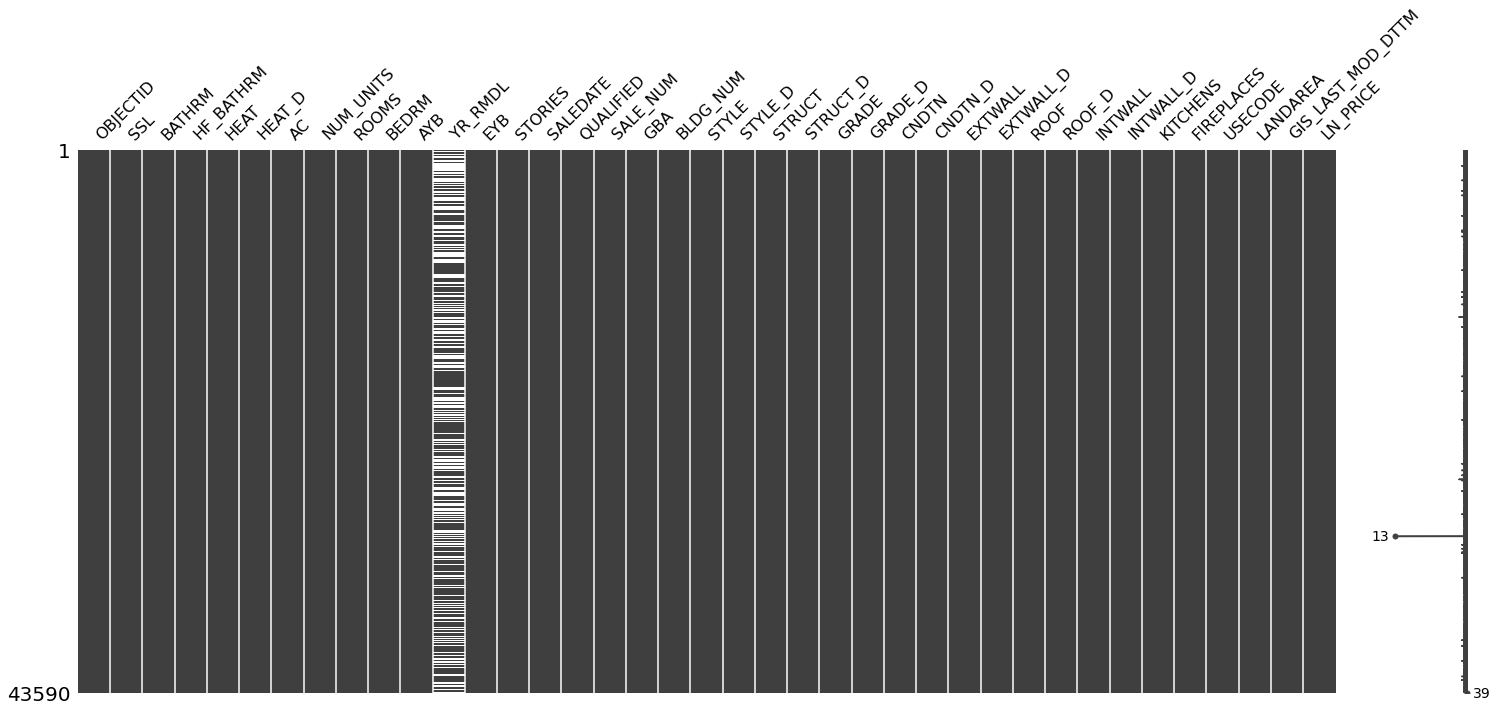

In [169]:
# Visualize missing data

miss.matrix(train_data)

In [178]:
# Drop all observations where the outcome is missing 
train_data = train_data[~train_data.LN_PRICE.isna()]

# Only houses that are sold
train_data = train_data[train_data.LN_PRICE > 0]

train_data = train_data.dropna()

# Subsample
train_data = train_data.sample(1000,random_state=1988)

train_data.shape

(1000, 39)

In [171]:
# Drop all observations where the outcome is missing 
test_data = test_data[~test_data.LN_PRICE.isna()]

# Only houses that are sold
test_data = test_data[test_data.LN_PRICE > 0]

test_data = test_data.dropna()

test_data.shape

(8328, 39)

In [179]:
train_y = train_data['LN_PRICE'] # OUTCOME: log selling price (some houses are ridiculuously expensive)
train_X = train_data[['BATHRM','BEDRM','LANDAREA']] # PREDICTORS: simplified for our purposes
train_X['LANDAREA'] = np.log(train_X['LANDAREA']) # Log land area (some house are on a lot of land, other on barely a plot)


test_y = test_data['LN_PRICE']
test_X = test_data[['BATHRM','BEDRM','LANDAREA']] # PREDICTORS: simplified for our purposes
test_X['LANDAREA'] = np.log(test_X['LANDAREA']) # Log land area (some house are on a lot of land, other on barely a plot)



## Explore training data

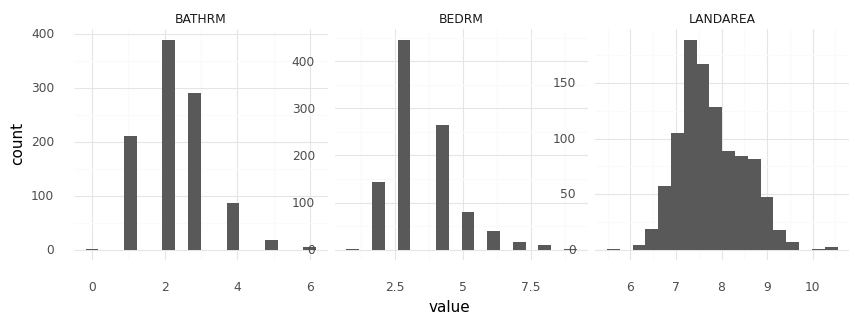

<ggplot: (302302136)>

In [180]:
# Visualizse distribution of data

(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 

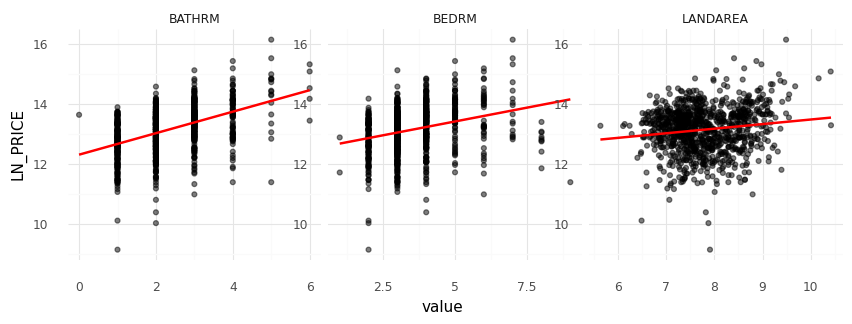

<ggplot: (303232458)>

In [181]:
D = train_X.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

## Compare Models

In [182]:

fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

use_metrics = ["neg_mean_squared_error"]

lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)



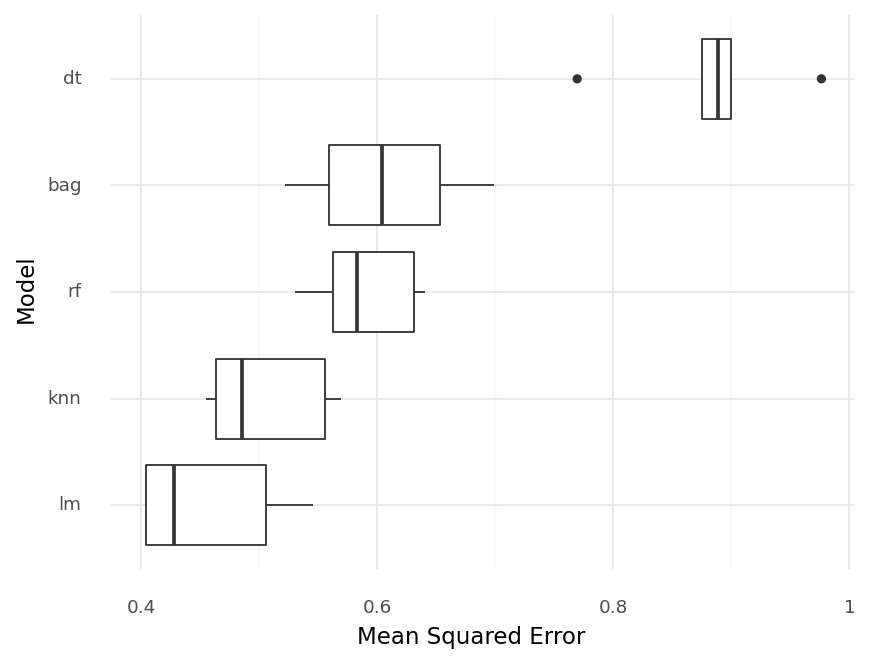

<ggplot: (302579935)>

In [183]:
# Collect the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")

# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot boxplots
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)


Lower MSE is better. It appears that the linear regression model has the lowest MSE.

## Modeling Pipeline

In [184]:

# Specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','BEDRM','LANDAREA'])])


# Create model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)


search.fit(train_X,train_y)
search.best_params_

{'model': RandomForestRegressor(max_depth=3, n_estimators=1250),
 'model__max_depth': 3,
 'model__n_estimators': 1250}

In [185]:
# Mean out-of-sample error
search.best_score_

-0.44570892594910233

## Test Performance

In [186]:
pred_y = search.predict(test_X)

m.mean_squared_error(test_y,pred_y)

0.45448244459362525

In [187]:
m.r2_score(test_y,pred_y)

0.2500352308494477

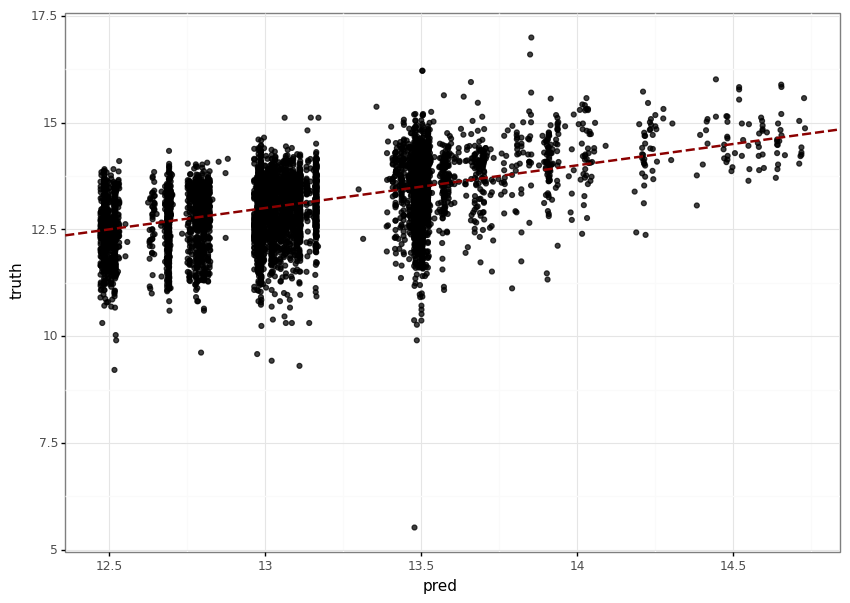

<ggplot: (306258520)>

In [188]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

Our modeling pipeline indicates that a random forest regressor is the best model for our data. When we test the performance on our test data the MSE is 0.454 and the R^2 is 0.25.